In [ ]:
# Import necessary libraries
import pandas as pd
import contextlib
import io
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, classification_report, confusion_matrix, make_scorer
import xgboost as xgb
from statsmodels.tsa.stattools import adfuller  # ADF test function
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from keras.callbacks import EarlyStopping
from datetime import datetime
import time
# TUNING
from tensorflow.keras.optimizers import Adam
!pip install keras-tuner
import keras_tuner as kt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# load the dataset
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

In [ ]:
# Display the first few rows of the DataFrame
df.head()

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,5545,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,02-10-2012 09:00
1,4516,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,02-10-2012 10:00
2,4767,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,02-10-2012 11:00
3,5026,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,02-10-2012 12:00
4,4918,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,02-10-2012 13:00


In [ ]:
# Check the shape of the dataset
print(f"there are {df.shape[0]} rows and {df.shape[1]} columns")

# show the column data types
print(df.dtypes)

# There are 48204 rows and 9 columns

there are 48204 rows and 9 columns
traffic_volume           int64
holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
date_time               object
dtype: object


In [ ]:
# Check duplication and drop them
print("Number of duplicate value in dataset: ",df.duplicated().sum())
df.drop_duplicates()
print(f"{df.duplicated().sum()} are drop from dataset.")

Number of duplicate value in dataset:  17
17 are drop from dataset.


In [ ]:
# Check null values -  majority of holiday column is empty (null values), therefore we will drop it
missing_values = df.isnull().sum()
print(f"Missing values in each column:\n{missing_values}")

df = df.drop('holiday', axis=1)

Missing values in each column:
traffic_volume             0
holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
dtype: int64


In [ ]:
# Convert 'date_time' to datetime format
df['date_time'] = pd.to_datetime(df['date_time'], format='%d-%m-%Y %H:%M')
# Extract features from 'date_time'
df['day'] = df['date_time'].dt.day_name()
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year
df['hour'] = df['date_time'].dt.hour
df.drop('date_time', axis=1, errors='ignore', inplace=True)

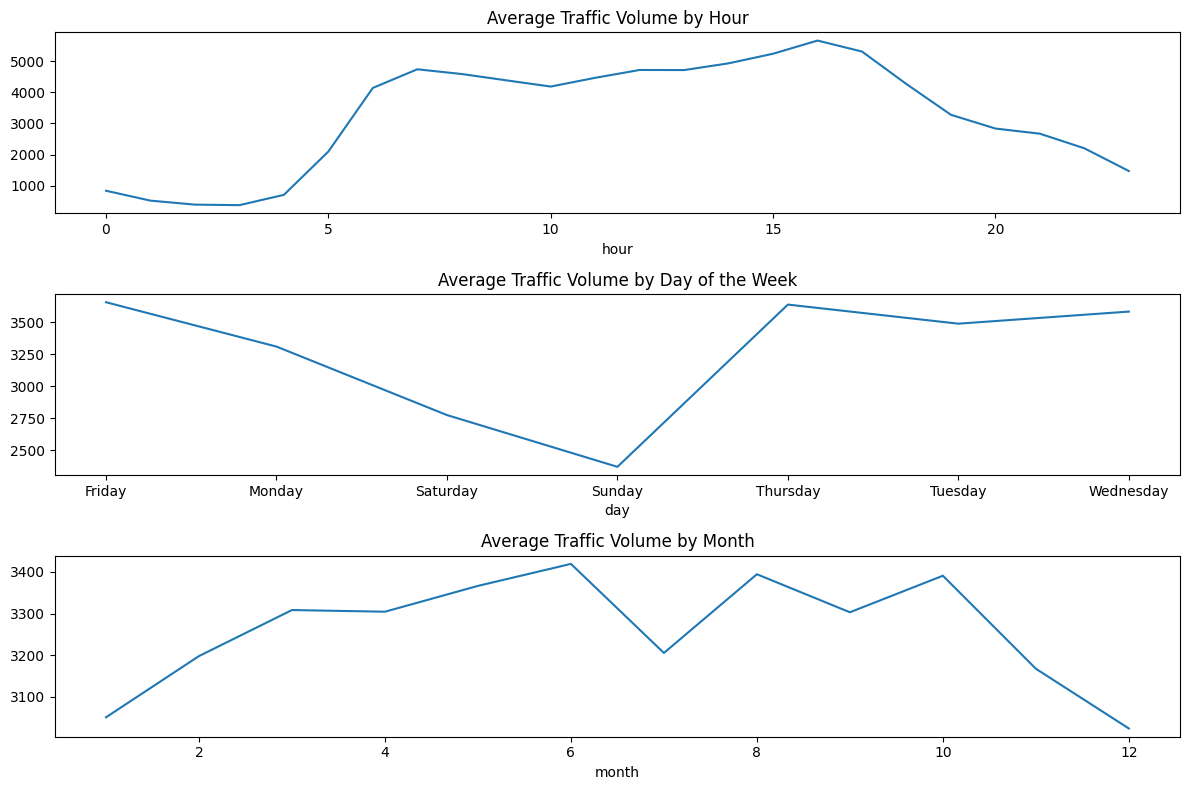

In [ ]:
# Plot to visualize some patterns
# - average traffic increases in the morning and again in the evening, when people when people are heading to work or returning from work.
# - It is seen that the traffic is the same on average for all the days but decrease over the weekend, which makes sense because on weekend the work traffic is less then usual.
# - It is also seen that during the month, the traffic is less in the summer and during the winters since it is festive season.

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
df.groupby('hour')['traffic_volume'].mean().plot()
plt.title('Average Traffic Volume by Hour')

plt.subplot(3, 1, 2)
df.groupby('day')['traffic_volume'].mean().plot()
plt.title('Average Traffic Volume by Day of the Week')

plt.subplot(3, 1, 3)
df.groupby('month')['traffic_volume'].mean().plot()
plt.title('Average Traffic Volume by Month')

plt.tight_layout()
plt.show()

In [ ]:
# Encode categorical features
catcol = ['weather_main', 'weather_description', 'day']
encoder =  LabelEncoder()
for col in catcol:
    df[col] = encoder.fit_transform(df[col])

In [ ]:
print(df.columns)# Perform statistical analysis
df.describe()

Index(['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_main', 'weather_description', 'day', 'month', 'year', 'hour'],
      dtype='object')


,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,day,month,year,hour
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,3259.818355,281.205870,0.334264,0.000222,49.362231,2.578375,16.540536,2.996183,6.506037,2015.512426,11.398162
std,1986.860670,13.338232,44.789133,0.008168,39.015750,2.784224,8.970108,2.002080,3.400221,1.893211,6.940238
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2012.000000,0.000000
25%,1193.000000,272.160000,0.000000,0.000000,1.000000,0.000000,10.000000,1.000000,4.000000,2014.000000,5.000000
50%,3380.000000,282.450000,0.000000,0.000000,64.000000,1.000000,17.000000,3.000000,7.000000,2016.000000,11.000000
75%,4933.000000,291.806000,0.000000,0.000000,90.000000,5.000000,27.000000,5.000000,9.000000,2017.000000,17.000000
max,7280.000000,310.070000,9831.300000,0.510000,100.000000,10.000000,37.000000,6.000000,12.000000,2018.000000,23.000000


In [ ]:
# Select only numeric columns for calculating IQR
numeric_df = df.select_dtypes(include=[float, int])

# Calculate the IQR for each numerical column
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Find outliers based on the IQR method
outliers = ((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR)))

# Display the number of outliers in each column
outliers.sum()

,0
traffic_volume,0
temp,10
rain_1h,3467
snow_1h,63
clouds_all,0
weather_main,0
weather_description,0
day,0
month,0
year,0


In [ ]:
df['rain_1h'].describe()

,rain_1h
count,48204.000000
mean,0.334264
std,44.789133
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,9831.300000


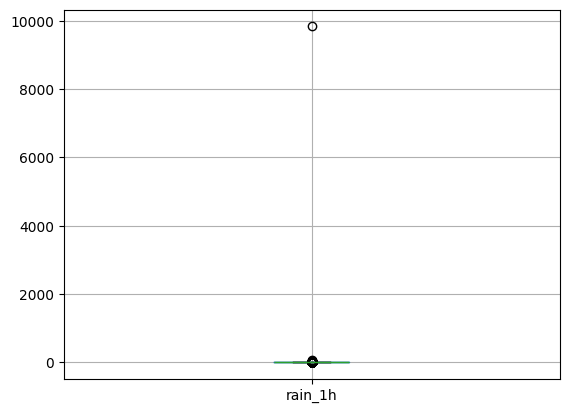

In [ ]:
df.boxplot(column='rain_1h')
plt.show()

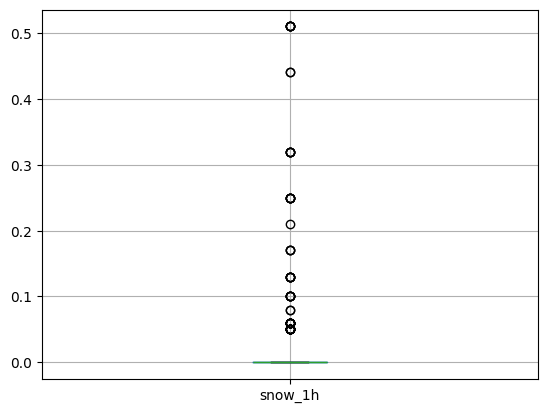

In [ ]:
df.boxplot(column='snow_1h')
plt.show()


Although the snow distribution has outliers, theyre considered in reasonable range

In [ ]:
def train_XGBoost_basic_model(df):

    # Scale target and temp feature
    scaler = MinMaxScaler()


        # Scale target and temp feature
    df['traffic_volume'] = scaler.fit_transform(df[['traffic_volume']])
    df['temp'] = scaler.fit_transform(df[['temp']])

    # Separate features (X) and target (y)
    X = df.drop('traffic_volume', axis=1)
    y = df['traffic_volume']

    # Split data into training and testing sets (70% train, 30% test)
    split_index = int(0.8 * len(df))
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Prepare data for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set XGBoost parameters
    params = {'max_depth': 6,
              'eta': 0.5, # Learning rate
              'objective': 'reg:squarederror', # Regression objective
              'eval_metric': 'rmse' # Evaluation metric
              }

    # Train the model with early stopping
    evals_result = {}
    model = xgb.train(params, dtrain, num_boost_round=50,
                      evals=[(dtrain, 'train'), (dtest, 'test')],
                      early_stopping_rounds=10, evals_result=evals_result)


    # Make predictions and inverse scale for readability
    y_pred = model.predict(dtest)


     # Calculate evaluation metrics using scaled values
    mae_scaled = mean_absolute_error(y_test, y_pred)
    mse_scaled = mean_squared_error(y_test, y_pred)
    rmse_scaled = mean_squared_error(y_test, y_pred, squared=False)
    r2_scaled = r2_score(y_test, y_pred)

    print("\n--- XGBoost Basic Model Evaluation Metrics (Scaled Values) ---")
    print(f"Mean Absolute Error (MAE):      {mae_scaled:.4f}")
    print(f"Mean Squared Error (MSE):       {mse_scaled:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_scaled:.4f}")
    print(f"R-squared (R2):                 {r2_scaled:.4f}")
    print("-" * 35)


    # Inverse scale predictions and actual values for original scale evaluation
    y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_original = scaler.inverse_transform(y_test.to_numpy().reshape(-1, 1))

    # Calculate evaluation metrics using original (inverse-scaled) values
    mae_original = mean_absolute_error(y_test_original, y_pred_original)
    mse_original = mean_squared_error(y_test_original, y_pred_original)
    rmse_original = mean_squared_error(y_test_original, y_pred_original, squared=False)
    r2_original = r2_score(y_test_original, y_pred_original)

    print("\n--- XGBoost Basic Model Evaluation Metrics (Original Values) ---")
    print(f"Mean Absolute Error (MAE):      {mae_original:.4f}")
    print(f"Mean Squared Error (MSE):       {mse_original:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_original:.4f}")
    print(f"R-squared (R2):                 {r2_original:.4f}")
    print("-" * 35)


    # Plot training vs. testing loss
    plt.figure(figsize=(10, 6))
    plt.plot(evals_result['train']['rmse'], label='Training RMSE')
    plt.plot(evals_result['test']['rmse'], label='Testing RMSE')
    plt.legend()
    plt.xlabel("Boosting Rounds")
    plt.ylabel("RMSE")
    plt.title('XGBoost Basic Model - Training vs Testing Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Add space between plots
    plt.figure(figsize=(10, 6))

    # Plot actual vs predicted values for the first 100 points (in original scale)
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_original[:100], label='Actual Traffic Volume')
    plt.plot(y_pred_original[:100], label='Predicted Traffic Volume')
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("Traffic Volume")
    plt.title('XGBoost Basic Model - Actual vs Predicted Traffic Volume (First 100 Points)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(10, 6))

    # Plot actual vs predicted values for the last year (assuming ~365 data points, in original scale)
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_original[-365:], label='Actual Traffic Volume')
    plt.plot(y_pred_original[-365:], label='Predicted Traffic Volume')
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("Traffic Volume")
    plt.title('XGBoost Basic Model - Actual vs Predicted Traffic Volume (Last Year)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

[0]	train-rmse:0.15288	test-rmse:0.15210
[1]	train-rmse:0.09961	test-rmse:0.10206
[2]	train-rmse:0.08006	test-rmse:0.08452
[3]	train-rmse:0.07276	test-rmse:0.07888
[4]	train-rmse:0.06888	test-rmse:0.07588
[5]	train-rmse:0.06562	test-rmse:0.07394
[6]	train-rmse:0.06423	test-rmse:0.07302
[7]	train-rmse:0.06299	test-rmse:0.07316
[8]	train-rmse:0.06214	test-rmse:0.07221
[9]	train-rmse:0.06144	test-rmse:0.07207
[10]	train-rmse:0.06020	test-rmse:0.07128
[11]	train-rmse:0.05988	test-rmse:0.07136
[12]	train-rmse:0.05918	test-rmse:0.07136
[13]	train-rmse:0.05858	test-rmse:0.07121
[14]	train-rmse:0.05844	test-rmse:0.07120
[15]	train-rmse:0.05744	test-rmse:0.07133
[16]	train-rmse:0.05713	test-rmse:0.07131
[17]	train-rmse:0.05665	test-rmse:0.07146
[18]	train-rmse:0.05626	test-rmse:0.07150
[19]	train-rmse:0.05577	test-rmse:0.07161
[20]	train-rmse:0.05542	test-rmse:0.07163
[21]	train-rmse:0.05528	test-rmse:0.07162
[22]	train-rmse:0.05487	test-rmse:0.07139
[23]	train-rmse:0.05463	test-rmse:0.07152

-

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


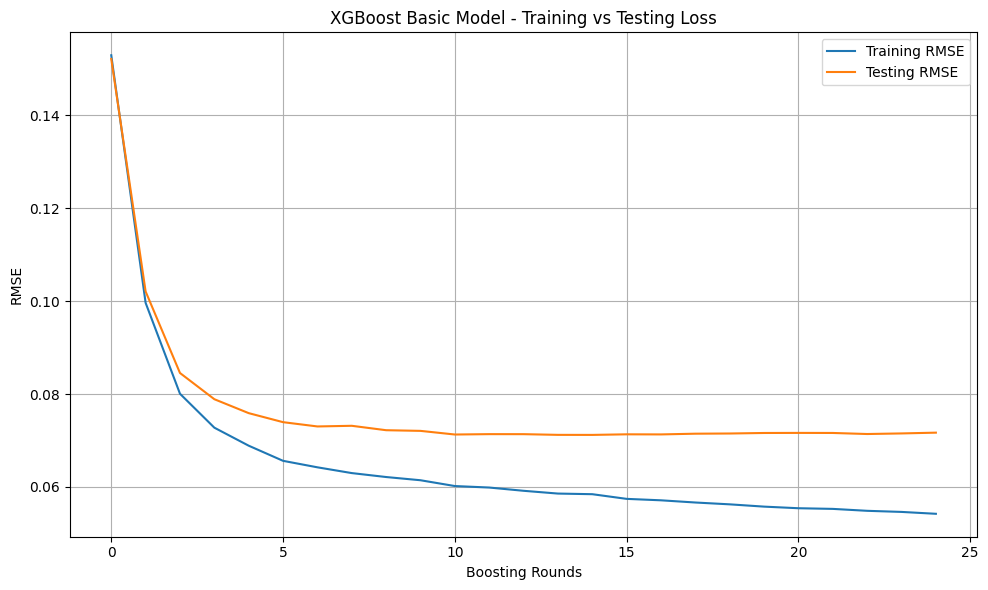

<Figure size 1000x600 with 0 Axes>

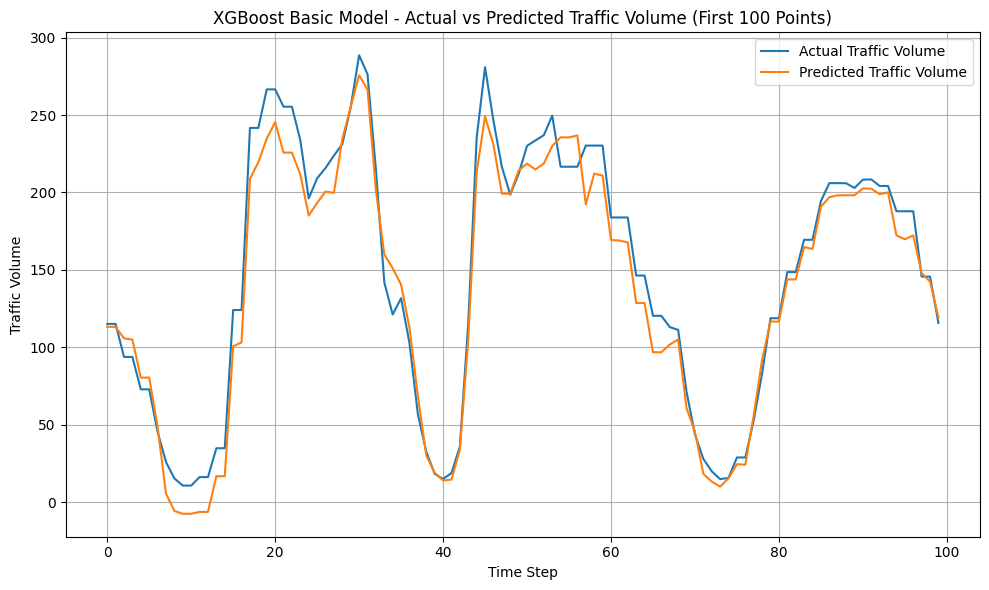

<Figure size 1000x600 with 0 Axes>

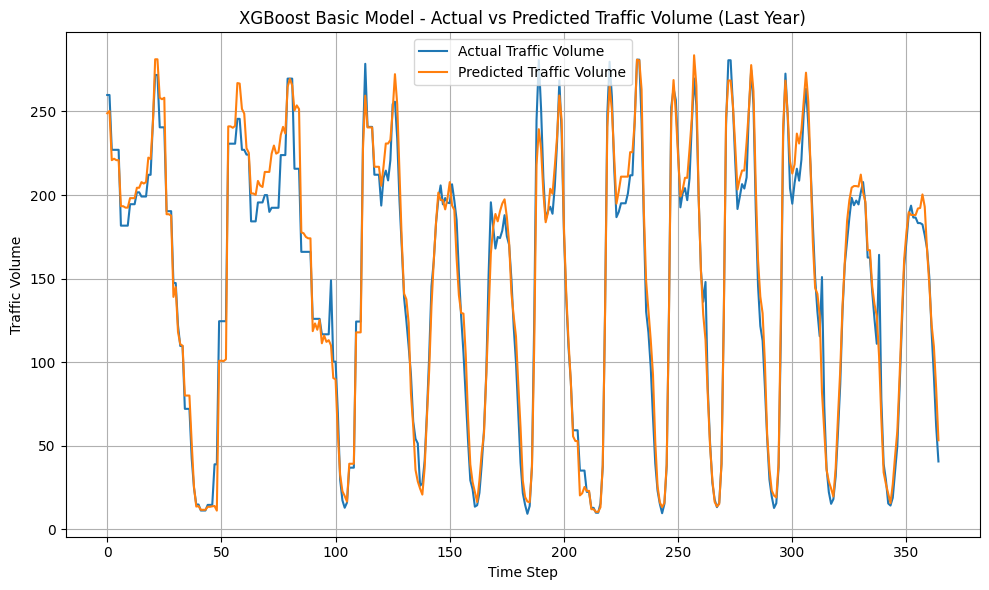

In [ ]:
train_XGBoost_basic_model(df.copy())

In [ ]:
def train_XGBoost_timeseries_model(df, plot_graphs=True, display_values=True):

      # Scale target and temp feature
    scaler_XG = MinMaxScaler()
    df['traffic_volume'] = scaler_XG.fit_transform(df[['traffic_volume']])
    df['temp'] = scaler_XG.fit_transform(df[['temp']])

  # Create lagged features (12-hour lags)
    # we firste define the number of lags ( 12 hours for hourly data)
    n_lags = 12

  # Create lag features for 'traffic_volume'
    for lag in range(1, n_lags + 1):
      df[f'traffic_volume_lag_{lag}'] = df['traffic_volume'].shift(lag)

    # Drop rows with NaN values caused by lagging
    df.dropna(inplace=True)

    # Define lagged features and target
    lag_features_XG = [col for col in df.columns if 'traffic_volume_lag' in col]
    target_feature_XG = 'traffic_volume'

    # Split the data into training and testing sets (80% training, 20% testing)
    train_size = int(len(df) * 0.8)
    train_df, test_df_XG = df[:train_size], df[train_size:]

    # Define training and testing sets
    X_train, y_train = train_df[lag_features_XG], train_df[target_feature_XG]
    X_test, y_test = test_df_XG[lag_features_XG], test_df_XG[target_feature_XG]

    # Convert data to XGBoost DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set XGBoost parameters
    params = {
        'max_depth': 6,
        'eta': 0.5,  # Learning rate
        'objective': 'reg:squarederror',  # Regression objective
        'eval_metric': 'rmse'  # Evaluation metric
    }

    # Train the model with early stopping
    evals_result = {}
    model_XG = xgb.train(params, dtrain, num_boost_round=50,
                      evals=[(dtrain, 'train'), (dtest, 'test')],
                      early_stopping_rounds=10, evals_result=evals_result)


    # Make predictions and inverse scale for readability
    y_pred = model_XG.predict(dtest)


   # Calculate evaluation metrics using scaled values
    mae_scaled = mean_absolute_error(y_test, y_pred)
    mse_scaled = mean_squared_error(y_test, y_pred)
    rmse_scaled = mean_squared_error(y_test, y_pred, squared=False)
    r2_scaled = r2_score(y_test, y_pred)


    if display_values:
        # Print evaluation metrics
        print("\n--- XGBoost Model Evaluation Metrics (Scaled Values) ---")
        print(f"Mean Absolute Error (MAE):      {mae_scaled:.4f}")
        print(f"Mean Squared Error (MSE):       {mse_scaled:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse_scaled:.4f}")
        print(f"R-squared (R2):                 {r2_scaled:.4f}")
        print("-" * 35)


    y_pred_orig = scaler_XG.inverse_transform(y_pred.reshape(-1, 1))
    y_test_orig = scaler_XG.inverse_transform(y_test.to_numpy().reshape(-1, 1))

    # Calculate evaluation metrics using scaled values
    mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)
    mse_orig = mean_squared_error(y_test_orig, y_pred_orig)
    rmse_orig = mean_squared_error(y_test_orig, y_pred_orig, squared=False)
    r2_orig = r2_score(y_test_orig, y_pred_orig)

    if display_values:
      # Print evaluation metrics
      print("\n--- XGBoost Model Evaluation Metrics (Original Values) ---")
      print(f"Mean Absolute Error (MAE):      {mae_orig:.4f}")
      print(f"Mean Squared Error (MSE):       {mse_orig:.4f}")
      print(f"Root Mean Squared Error (RMSE): {rmse_orig:.4f}")
      print(f"R-squared (R2):                 {r2_orig:.4f}")
      print("-" * 35)


    if plot_graphs:

      # Plot training vs. testing loss
      plt.figure(figsize=(10, 6))
      plt.plot(evals_result['train']['rmse'], label='Training RMSE')
      plt.plot(evals_result['test']['rmse'], label='Testing RMSE')
      plt.legend()
      plt.xlabel("Boosting Rounds")
      plt.ylabel("RMSE")
      plt.title('XGBoost timeseries model - Training vs Testing Loss')
      plt.grid(True)
      plt.tight_layout()
      plt.show()


      plt.figure(figsize=(10, 6))

      # Plot actual vs predicted values for the first 100 points
      plt.plot(y_test_orig[:100], label='Actual Traffic Volume')
      plt.plot(y_pred_orig[:100], label='Predicted Traffic Volume')
      plt.legend()
      plt.xlabel("Time Step")
      plt.ylabel("Traffic Volume")
      plt.title('XGBoost timeseries model - Actual vs Predicted Traffic Volume')
      plt.grid(True)
      plt.tight_layout()
      plt.show()

      plt.figure(figsize=(10, 6))

      # Plot actual vs predicted values for the last year (assuming ~365 data points for daily data)
      plt.figure(figsize=(10, 6))
      plt.plot(y_test_orig[-365:], label='Actual Traffic Volume')
      plt.plot(y_pred_orig[-365:], label='Predicted Traffic Volume')
      plt.legend()
      plt.xlabel("Time Step")
      plt.ylabel("Traffic Volume")
      plt.title('XGBoost timeseries model - Actual vs Predicted Traffic Volume (Last Year)')
      plt.grid(True)
      plt.tight_layout()  # Adjust layout to prevent overlap
      plt.show()


      model_XG.save_model('xgboost_timeseries_model.json')

# Return all evaluation metrics
    return mse_scaled, mae_scaled, rmse_scaled, r2_scaled, model_XG, scaler_XG, test_df_XG, lag_features_XG, target_feature_XG


[0]	train-rmse:0.15262	test-rmse:0.14807
[1]	train-rmse:0.09958	test-rmse:0.09208
[2]	train-rmse:0.07907	test-rmse:0.06934
[3]	train-rmse:0.07174	test-rmse:0.06066
[4]	train-rmse:0.06897	test-rmse:0.05763
[5]	train-rmse:0.06743	test-rmse:0.05631
[6]	train-rmse:0.06642	test-rmse:0.05578
[7]	train-rmse:0.06562	test-rmse:0.05545
[8]	train-rmse:0.06520	test-rmse:0.05530
[9]	train-rmse:0.06469	test-rmse:0.05528
[10]	train-rmse:0.06436	test-rmse:0.05524
[11]	train-rmse:0.06374	test-rmse:0.05506
[12]	train-rmse:0.06322	test-rmse:0.05502
[13]	train-rmse:0.06298	test-rmse:0.05500
[14]	train-rmse:0.06258	test-rmse:0.05503
[15]	train-rmse:0.06206	test-rmse:0.05498
[16]	train-rmse:0.06127	test-rmse:0.05472
[17]	train-rmse:0.06070	test-rmse:0.05460
[18]	train-rmse:0.06020	test-rmse:0.05438
[19]	train-rmse:0.05992	test-rmse:0.05438
[20]	train-rmse:0.05972	test-rmse:0.05433
[21]	train-rmse:0.05947	test-rmse:0.05419
[22]	train-rmse:0.05921	test-rmse:0.05415
[23]	train-rmse:0.05878	test-rmse:0.05404
[2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


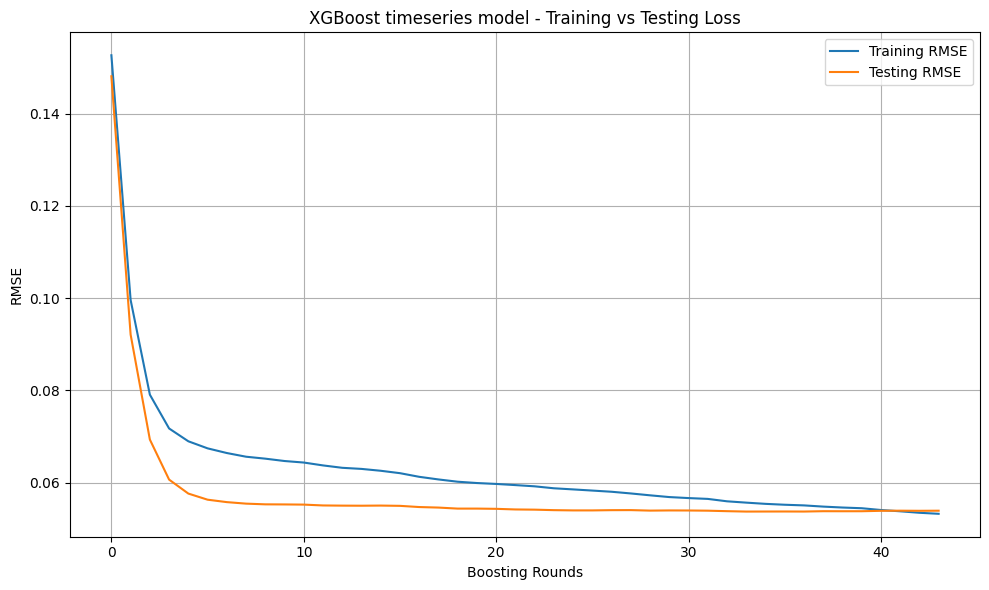

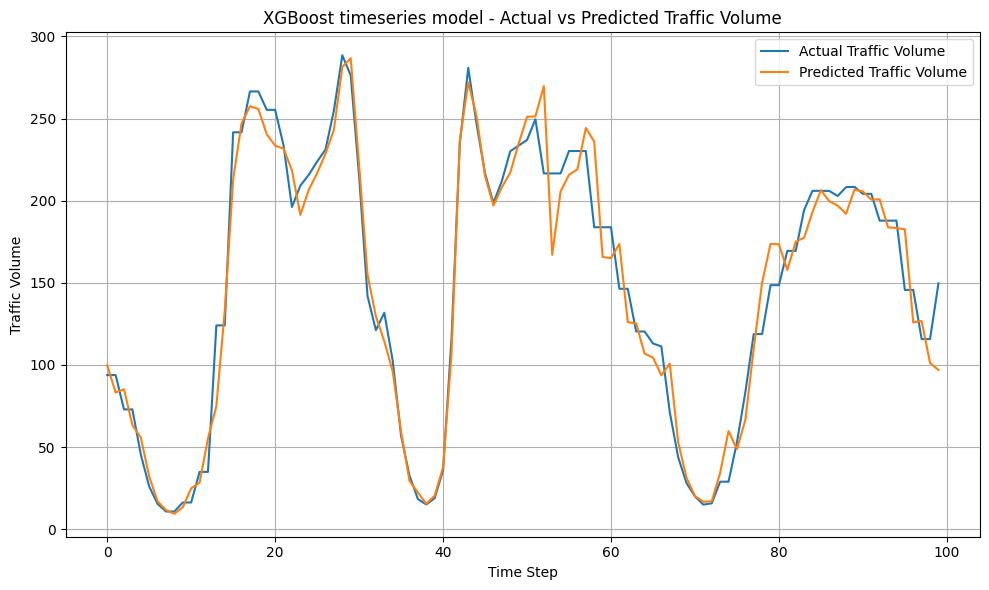

<Figure size 1000x600 with 0 Axes>

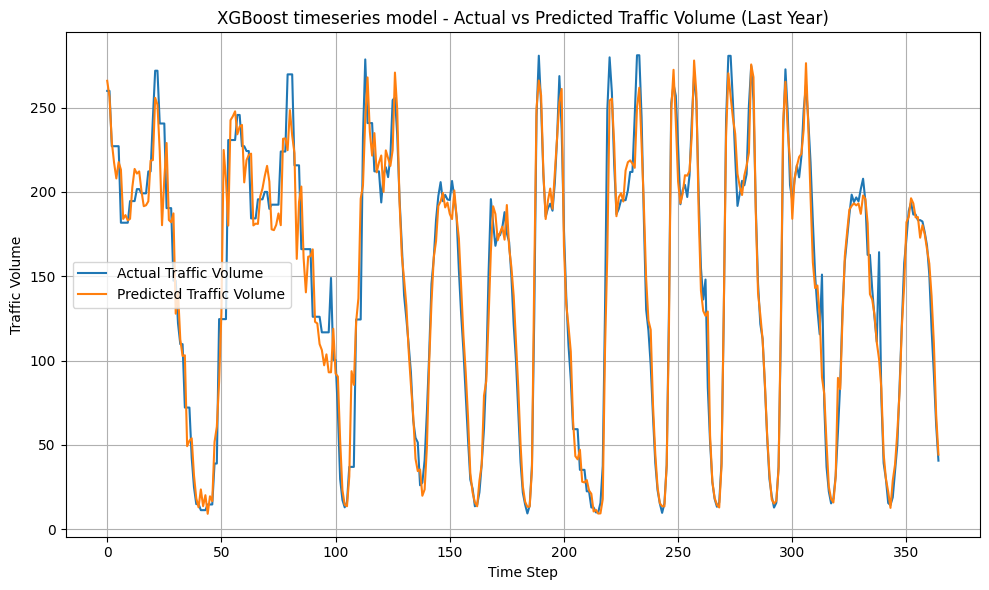

In [ ]:
# Call the function and get the required variables
_, _, _, _,model_XG, scaler_XG, test_df_XG, lag_features_XG, target_feature_XG = train_XGBoost_timeseries_model(df)

In [ ]:
# creating lag features for the target variable 'traffic_volume'.

# we first define the number of lags ( 12 hours for hourly data)
n_lags = 12

# Create lag features for 'traffic_volume'
for lag in range(1, n_lags + 1):
    df[f'traffic_volume_lag_{lag}'] = df['traffic_volume'].shift(lag)
     #creates a new column for each lagged value by shifting the traffic_volume column down by the number of steps specified

# Drop rows with NaN values caused by the lagging
df.dropna(inplace=True)


print(df.head())

    traffic_volume    temp  rain_1h  snow_1h  clouds_all  weather_main  \
12            2361  288.61      0.0      0.0           1             0   
13            1529  287.16      0.0      0.0           1             0   
14             963  285.45      0.0      0.0           1             0   
15             506  284.63      0.0      0.0           1             0   
16             321  283.47      0.0      0.0           1             0   

    weather_description  day  month  year  ...  traffic_volume_lag_3  \
12                   27    5     10  2012  ...                4770.0   
13                   27    5     10  2012  ...                3539.0   
14                   27    5     10  2012  ...                2784.0   
15                   27    6     10  2012  ...                2361.0   
16                   27    6     10  2012  ...                1529.0   

    traffic_volume_lag_4  traffic_volume_lag_5  traffic_volume_lag_6  \
12                5791.0                6015.0    

In [ ]:
# Define input and output columns
input_features = [col for col in df.columns if 'traffic_volume_lag' in col]
target_feature = 'traffic_volume'

# Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(df) * 0.8)
train_df, test_df = df[:train_size], df[train_size:]

# Initialize scalers for input features and target
input_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale input features for X_train and X_test
X_train_scaled = input_scaler.fit_transform(train_df[input_features])
X_test_scaled = input_scaler.transform(test_df[input_features])

# Scale target feature for y_train and y_test
y_train_scaled = target_scaler.fit_transform(train_df[[target_feature]])
y_test_scaled = target_scaler.transform(test_df[[target_feature]])


**Basic Decision Tree Model**

In [ ]:
# Initialize and train the Decision Tree model
dt_regressor = DecisionTreeRegressor(random_state=42)
# Use the scaled input and target features for training
dt_regressor.fit(X_train_scaled, y_train_scaled) # change: using X_train_scaled instead of X_train and y_train_scaled instead of y_train
y_pred_dt = dt_regressor.predict(X_test_scaled) #change: using X_test_scaled instead of X_test

# Evaluate the Decision Tree model
# Reshape y_test_scaled and y_pred_dt to be 2D arrays
y_test_2d = y_test_scaled.reshape(-1, 1)
y_pred_dt_2d = y_pred_dt.reshape(-1, 1)

# Inverse transform the scaled target values to original scale
y_test_original = target_scaler.inverse_transform(y_test_2d)
y_pred_dt_original = target_scaler.inverse_transform(y_pred_dt_2d)

mse_dt = mean_squared_error(y_test_original, y_pred_dt_original) # change: using original target values for evaluation
mae_dt = mean_absolute_error(y_test_original, y_pred_dt_original) # change: using original target values for evaluation
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test_original, y_pred_dt_original) # change: using original target values for evaluation

print("\nDecision Tree Regression Results:")
print("MSE:", mse_dt)
print("MAE:", mae_dt)
print("RMSE:", rmse_dt)
print("R2:", r2_dt)


Decision Tree Regression Results:
MSE: 339866.9992737836
MAE: 346.32721236642806
RMSE: 582.9811311472985
R2: 0.9122349046033819


**Basic Random Forest Model**

In [ ]:
# Define input and output columns
input_features = [col for col in df.columns if 'traffic_volume_lag' in col]
target_feature = 'traffic_volume'

# Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(df) * 0.8)
train_df, test_df = df[:train_size], df[train_size:]

# Extract features and target for training and testing
X_train = train_df[input_features] # change: creating X_train from train_df
y_train = train_df[target_feature] # change: creating y_train from train_df
X_test = test_df[input_features]   # change: creating X_test from test_df
y_test = test_df[target_feature]   # change: creating y_test from test_df

# Initialize and train the Random Forest model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train) # change: using X_train and y_train
y_pred_rf = rf_regressor.predict(X_test) #change: using X_test instead of X_test_scaled

# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Regression Results:")
print("MSE:", mse_rf)
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print("R2:", r2_rf)


Random Forest Regression Results:
MSE: 140228.53528584915
MAE: 239.88573607220664
RMSE: 374.47100727005443
R2: 0.9637882736394291


**Basic SVR Model**

In [ ]:
# Initialize and train the Support Vector Machine (SVM) model
svm_regressor = SVR(kernel='rbf')
svm_regressor.fit(X_train, y_train)
y_pred_svm = svm_regressor.predict(X_test)

# Evaluate the SVM model
mse_svm = mean_squared_error(y_test, y_pred_svm)
mae_svm = mean_absolute_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)
r2_svm = r2_score(y_test, y_pred_svm)

print("SVM Regression Results:")
print("Mean Squared Error:", mse_svm)
print("Mean Absolute Error:", mae_svm)
print("RMSE:", rmse_svm)
print("R2:", r2_svm)

SVM Regression Results:
Mean Squared Error: 784409.4807690121
Mean Absolute Error: 643.1576130244324
RMSE: 885.6689453565662
R2: 0.797439077472049


**Create Sequence to train models**

In [ ]:
# Prepare input and output data for sequence creation
X_train, y_train = X_train_scaled, y_train_scaled
X_test, y_test = X_test_scaled, y_test_scaled

# Check if the test set has enough data points to create sequences
n_timesteps = 5
print("Length of X_test:", len(X_test))
print("n_timesteps:", n_timesteps)

if len(X_test) <= n_timesteps:
    print(f"Error: No data points enough to create sequences of {n_timesteps} timesteps.")
else:
    print("Enough data points to create sequences.")

# Define sliding window function to create sequences
def create_sequences(data, target, n_timesteps):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        X.append(data[i:i + n_timesteps, :])
        y.append(target[i + n_timesteps])
    return np.array(X), np.array(y)

# Given that there are enough points, continue with creating sequences
if len(X_test) > n_timesteps:
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_timesteps)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, n_timesteps)




Length of X_test: 9639
n_timesteps: 5
Enough data points to create sequences.
Shape of X_train_seq: (38548, 5, 12)
Shape of y_train_seq: (38548, 1)
Shape of X_test_seq: (9634, 5, 12)
Shape of y_test_seq: (9634, 1)


**Creating RNN Model**

In [ ]:
# Define the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))  # dropout layer for regularization
model.add(Dense(units=1))   # Output layer for regression


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error',  metrics=[MeanSquaredError(name='mse'), MeanAbsoluteError(name='mae')])

# Display model summary

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Add EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True)

In [ ]:
# Train the model
training_model = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1, callbacks=[early_stop])

Epoch 1/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0782 - mae: 0.1991 - mse: 0.0782 - val_loss: 0.0151 - val_mae: 0.0907 - val_mse: 0.0151
Epoch 2/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0253 - mae: 0.1186 - mse: 0.0253 - val_loss: 0.0144 - val_mae: 0.0929 - val_mse: 0.0144
Epoch 3/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0238 - mae: 0.1136 - mse: 0.0238 - val_loss: 0.0154 - val_mae: 0.0873 - val_mse: 0.0154
Epoch 4/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0221 - mae: 0.1089 - mse: 0.0221 - val_loss: 0.0142 - val_mae: 0.0921 - val_mse: 0.0142
Epoch 5/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0215 - mae: 0.1069 - mse: 0.0215 - val_loss: 0.0132 - val_mae: 0.0894 - val_mse: 0.0132
Epoch 6/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0202 - mae: 0.1031 - mse: 0.0202 - val_loss: 0.0118 - val_mae: 0.0819 - val_mse: 0.0118
Epoch 7/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0190 - mae: 0.0992 - mse

In [ ]:

# Evaluate the model on the training set
train_loss = model.evaluate(X_train_seq, y_train_seq, verbose=1)
print(f"Training Loss: {train_loss}")

# Evaluate the model on the test set
test_loss = model.evaluate(X_test_seq, y_test_seq, verbose=1)
print(f"Test Loss: {test_loss}")

1205/1205 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0130 - mae: 0.0748 - mse: 0.0130
Training Loss: [0.012500124052166939, 0.012500124052166939, 0.07360122352838516]
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080 - mae: 0.0623 - mse: 0.0080
Test Loss: [0.007880322635173798, 0.007880322635173798, 0.06102250516414642]


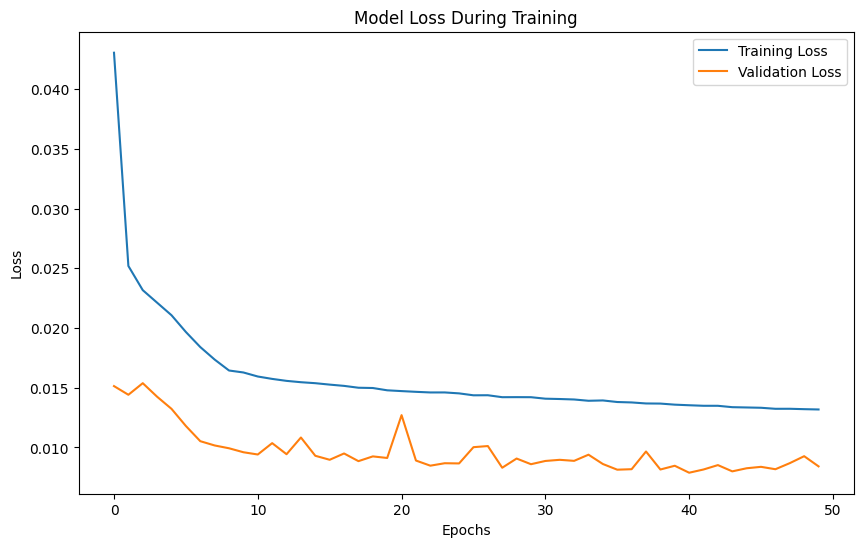

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(training_model.history['loss'], label='Training Loss')
plt.plot(training_model.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

302/302 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


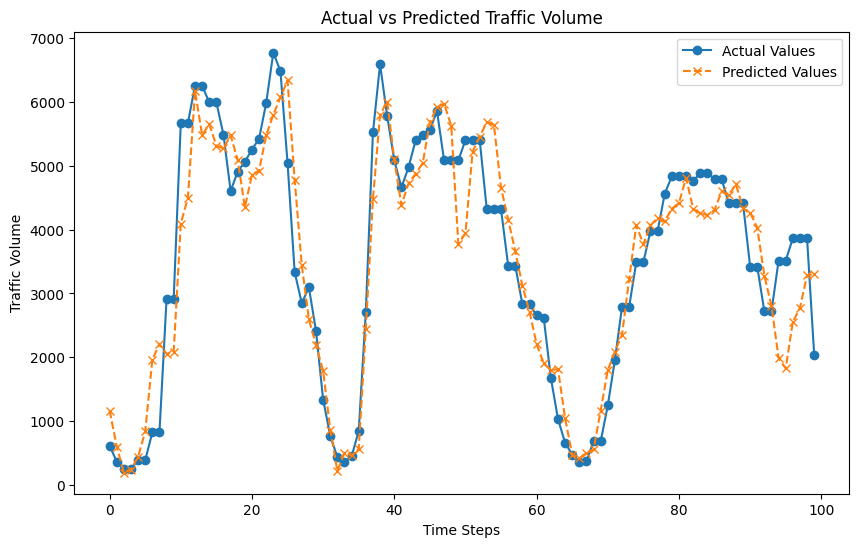

In [ ]:
# Generate predictions on the test set
predictions_scaled = model.predict(X_test_seq)

# Inverse transform predictions and y_test_seq for comparison
predictions = target_scaler.inverse_transform(predictions_scaled)
y_test_rescaled = target_scaler.inverse_transform(y_test_seq)



# Plot actual vs predicted values after rescaling
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_rescaled[:100])), y_test_rescaled[:100], label='Actual Values', marker='o', linestyle='-')
plt.plot(range(len(predictions[:100])), predictions[:100], label='Predicted Values', marker='x', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Volume')
plt.title('Actual vs Predicted Traffic Volume')
plt.legend()
plt.show()

In [ ]:

#Scaled

# Calculate Mean Squared Error (MSE)
mse_rnn = mean_squared_error(y_test_seq, predictions_scaled)
print(f"Mean Squared Error (MSE): {mse_rnn}")

# Calculate Mean Absolute Error (MAE)
mae_rnn = mean_absolute_error(y_test_seq, predictions_scaled)
print(f"Mean Absolute Error (MAE): {mae_rnn}")

# Calculate RMSE
rmse_rnn = np.sqrt(mse_rnn)
print(f"RMSE: {rmse_rnn}")

# Calculate R-squared
r_squared_rnn = r2_score(y_test_seq, predictions_scaled)
print(f"R-squared: {r_squared_rnn}")


Mean Squared Error (MSE): 0.007880325077278297
Mean Absolute Error (MAE): 0.06102249908162314
RMSE: 0.08877119508758625
R-squared: 0.8921720786036966


In [ ]:
#rescaled (after inverse)



# Calculate Mean Squared Error (MSE)
mse_rnn_original = mean_squared_error(y_test_rescaled, predictions)
print(f"Mean Squared Error (MSE): {mse_rnn_original}")

# Calculate Mean Absolute Error (MAE)
mae_rnn_original = mean_absolute_error(y_test_rescaled, predictions)
print(f"Mean Absolute Error (MAE): {mae_rnn_original}")

# Calculate RMSE
rmse_rnn_original= np.sqrt(mse_rnn_original)
print(f"RMSE: {rmse_rnn_original}")

# Calculate R-squared
r_squared_rnn_original= r2_score(y_test_rescaled, predictions)
print(f"R-squared: {r_squared_rnn_original}")

Mean Squared Error (MSE): 417644.62236367137
Mean Absolute Error (MAE): 444.24379382114677
RMSE: 646.2543016210193
R-squared: 0.8921720781420571


Training model with relu activation function.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0380 - val_loss: 0.0116
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0195 - val_loss: 0.0098
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0170 - val_loss: 0.0085
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0153 - val_loss: 0.0078
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0146 - val_loss: 0.0079
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0142 - val_loss: 0.0079
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0139 - val_loss: 0.0083
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0141 - val_loss: 0.0077
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0133 - val_loss: 0.0072
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0132 - val_loss: 0.0070
Training model with tanh activation function.
Epoch 1/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0588 - val_loss: 0.0

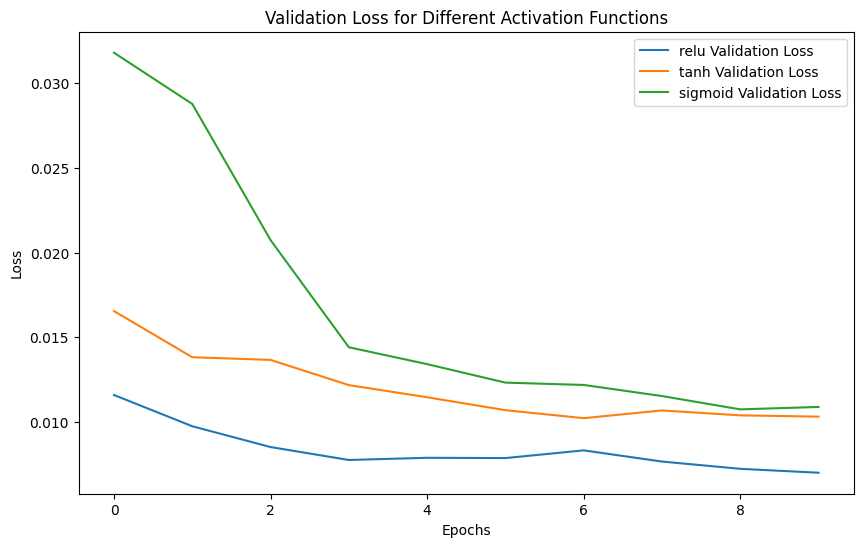

In [ ]:
# Define a function to create models with different activation functions
def create_rnn_model(activation_function):
    model = Sequential()
    model.add(SimpleRNN(units=50, activation=activation_function, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Try different activation functions
activations = ['relu', 'tanh', 'sigmoid']
training_histories = {}

for activation in activations:
    print(f"Training model with {activation} activation function.")
    model = create_rnn_model(activation)
    training_model = model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)
    training_histories[activation] = training_model.history  # Store training history for later comparison

# Plotting validation loss for each activation function
plt.figure(figsize=(10, 6))
for activation in activations:
    plt.plot(training_histories[activation]['val_loss'], label=f'{activation} Validation Loss')

plt.title('Validation Loss for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Define the model-building function for Keras Tuner
def create_rnn_tuned_model(hyperparams):
    tuned_model = Sequential()
    for layer in range(hyperparams.Int('num_hidden_layers', min_value=1, max_value=5, step=1)):
        tuned_model.add(SimpleRNN(
            units=hyperparams.Int(f'layer_units_{layer}', min_value=50, max_value=300, step=50),
            activation=hyperparams.Choice('activation_func', values=['relu']),
            return_sequences=True if layer < hyperparams.Int('num_hidden_layers', 1, 5) - 1 else False,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if layer == 0 else None
        ))
        tuned_model.add(Dropout(rate=hyperparams.Float(f'dropout_rate_{layer}', min_value=0.1, max_value=0.5, step=0.1)))

    tuned_model.add(Dense(1))  # Output layer

    tuned_model.compile(
        optimizer=Adam(learning_rate=hyperparams.Float('learning_rate_param', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='mean_squared_error',
        metrics=['mse', 'mae']
    )

    return tuned_model

# Initialize the Keras Tuner with Bayesian Optimization
hyperparam_tuning = kt.BayesianOptimization(
    create_rnn_tuned_model,
    objective='val_loss',
    max_trials=8,
    directory='tuned_rnn_results',
    project_name='traffic_prediction_tuned'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Adjust patience as needed
    restore_best_weights=True
)

# Perform the search
hyperparam_tuning.search(
    X_train_seq, y_train_seq,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stopping],
    verbose=1
)

# Retrieve the best hyperparameters
optimal_hyperparams = hyperparam_tuning.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best number of layers: {optimal_hyperparams.get('num_hidden_layers')}
Best units per layer: {[optimal_hyperparams.get(f'layer_units_{i}') for i in range(optimal_hyperparams.get('num_hidden_layers'))]}
Best activation: {optimal_hyperparams.get('activation_func')}
Best dropout rates: {[optimal_hyperparams.get(f'dropout_rate_{i}') for i in range(optimal_hyperparams.get('num_hidden_layers'))]}
Best learning rate: {optimal_hyperparams.get('learning_rate_param')}
""")

Trial 8 Complete [00h 04m 56s]
val_loss: 0.014674277976155281

Best val_loss So Far: 0.006164921447634697
Total elapsed time: 00h 39m 17s

Best number of layers: 1
Best units per layer: [100]
Best activation: relu
Best dropout rates: [0.30000000000000004]
Best learning rate: 0.0007247207282956783



In [ ]:
# Define the RNN model
model2 = Sequential()

# Add RNN layer
model2.add(SimpleRNN(
    units=100,  # Best units per layer
    activation='relu',  # Best activation function
    input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])  # Match input shape of the dataset
))

# Add dropout layer
model2.add(Dropout(0.3))  # Best dropout rate

# Add output layer for regression
model2.add(Dense(1))

# Compile the model
model2.compile(
    optimizer=Adam(learning_rate=0.0007247207282956783),  # Best learning rate
    loss='mean_squared_error',
    metrics=['mae', 'mse']
)

# Display the model summary
model2.summary()

# Define early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
rnn_2 = model2.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)             │ (None, 100)                 │          11,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,401 (44.54 KB)

 Trainable params: 11,401 (44.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0393 - mae: 0.1466 - mse: 0.0393 - val_loss: 0.0112 - val_mae: 0.0770 - val_mse: 0.0112
Epoch 2/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0185 - mae: 0.0991 - mse: 0.0185 - val_loss: 0.0096 - val_mae: 0.0700 - val_mse: 0.0096
Epoch 3/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0164 - mae: 0.0920 - mse: 0.0164 - val_loss: 0.0092 - val_mae: 0.0696 - val_mse: 0.0092
Epoch 4/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0150 - mae: 0.0872 - mse: 0.0150 - val_loss: 0.0089 - val_mae: 0.0666 - val_mse: 0.0089
Epoch 5/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0142 - mae: 0.0850 - mse: 0.0142 - val_loss: 0.0073 - val_mae: 0.0603 - val_mse: 0.0073
Epoch 6/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0141 - mae: 0.0840 - mse: 0.0141 - val_loss: 0.0076 - val_mae: 0.0631 - val_mse: 0.0076
Epoch 7/50
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0136 - mae: 0.0825 - ms

In [ ]:
# Generate predictions on the test set
predictions_scaled2 = model2.predict(X_test_seq)

# Inverse transform predictions and y_test_seq for comparison
predictions2 = target_scaler.inverse_transform(predictions_scaled2)
y_test_rescaled = target_scaler.inverse_transform(y_test_seq)







302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
#scaled
# Calculate Mean Squared Error (MSE)
mse_tunning_rnn = mean_squared_error(y_test_seq, predictions_scaled2)
print(f"Mean Squared Error (MSE): {mse_tunning_rnn}")

# Calculate Mean Absolute Error (MAE)
mae_tunning_rnn = mean_absolute_error(y_test_seq, predictions_scaled2)
print(f"Mean Absolute Error (MAE): {mae_tunning_rnn}")

# Calculate RMSE
rmse_tunning_rnn = np.sqrt(mse_tunning_rnn)
print(f"RMSE: {rmse_rnn}")

# Calculate R-squared
r_squared_tunning_rnn = r2_score(y_test_seq, predictions_scaled2)
print(f"R-squared: {r_squared_tunning_rnn}")

Mean Squared Error (MSE): 0.005644489857655745
Mean Absolute Error (MAE): 0.05107607252200196
RMSE: 0.08877119508758625
R-squared: 0.9227654185931445


In [ ]:
#after inverse
# Calculate Mean Squared Error (MSE)
mse_tuning_rnn_original = mean_squared_error(y_test_rescaled, predictions2)
print(f"Mean Squared Error (MSE): {mse_tuning_rnn_original}")

# Calculate Mean Absolute Error (MAE)
mae_tuning_rnn_original = mean_absolute_error(y_test_rescaled, predictions2)
print(f"Mean Absolute Error (MAE): {mae_tuning_rnn_original}")

# Calculate RMSE
rmse_tuning_rnn_original= np.sqrt(mse_tuning_rnn_original)
print(f"RMSE: {rmse_tuning_rnn_original}")

# Calculate R-squared
r_squared_tunning_rnn_original= r2_score(y_test_rescaled, predictions2)
print(f"R-squared: {r_squared_tunning_rnn_original}")

Mean Squared Error (MSE): 299148.93226952665
Mean Absolute Error (MAE): 371.8338091780789
RMSE: 546.9450907262325
R-squared: 0.9227654183355974


**Decision Tree Regressor**

In [ ]:
# Define the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Define the parameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Use GridSearchCV with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=dt_regressor,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=1)

# Fit the model on the training data
grid_search.fit(X_train, y_train.ravel())  # Use ravel() to flatten y_train if necessary

# Retrieve the best model from the grid search
best_dt_model = grid_search.best_estimator_

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", -grid_search.best_score_)

# Evaluate the model on the test data
y_pred = best_dt_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test RMSE:", rmse)
print("Test R^2 Score:", r2)




Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best Cross-Validation Score: 0.006424320774521904
Test MSE: 0.003390451237397784
Test MAE: 0.038412496855575205
Test RMSE: 0.0582275814146336
Test R^2 Score: 0.9535983853221734


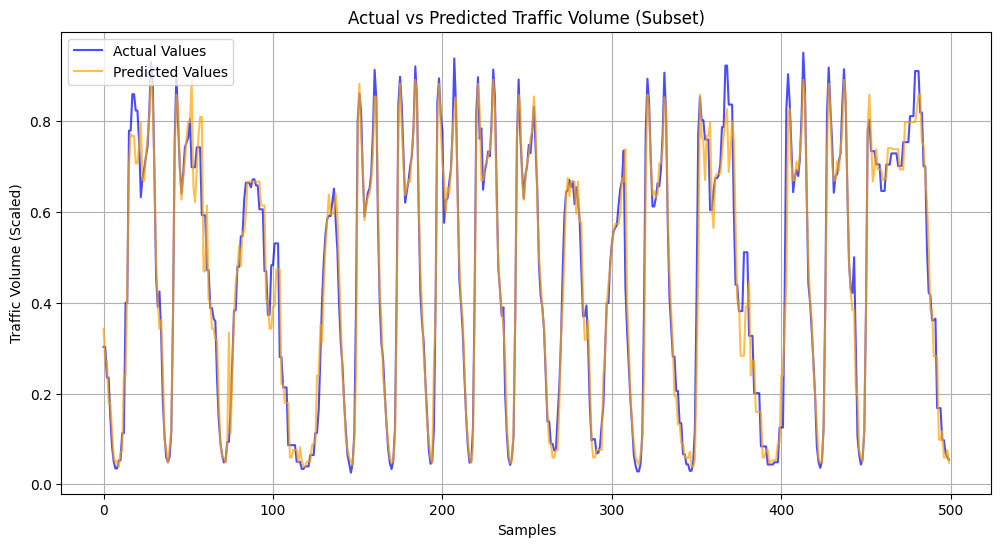

In [ ]:
# Plot Actual vs Predicted for a subset of data for clarity (first 500 samples)
subset_size = 500
plt.figure(figsize=(12, 6))
plt.plot(y_test[:subset_size], label='Actual Values', color='blue', alpha=0.7)
plt.plot(y_pred[:subset_size], label='Predicted Values', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Traffic Volume (Subset)')
plt.xlabel('Samples')
plt.ylabel('Traffic Volume (Scaled)')
plt.legend()
plt.grid()
plt.show()


**Random Forest Regressor**

In [ ]:
#Random Forest Regressor with randomized search

# Define parameter grid with smaller search space
param_grid = {
    'n_estimators': [10, 20, 50],
    'max_depth': [5, 10],
    'min_samples_split': [5],
    'min_samples_leaf': [2],
    'max_features': ['sqrt']
}

# Use RandomizedSearchCV
randomized_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                       param_distributions=param_grid,
                                       scoring='neg_mean_squared_error',
                                       cv=3,
                                       n_iter=5,
                                       n_jobs=-1,  # Use all CPU cores
                                       random_state=42,
                                       verbose=1)
randomized_search.fit(X_train, y_train.ravel())
best_rf_model = randomized_search.best_estimator_


Fitting 3 folds for each of 5 candidates, totalling 15 fits


Best Random Forest Model Parameters:
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=50, random_state=42)
Test MSE: 0.003390451237397784
Test MAE: 0.03781771759213707
Test RMSE: 0.0582275814146336
Test R^2 Score: 0.9594823552477673


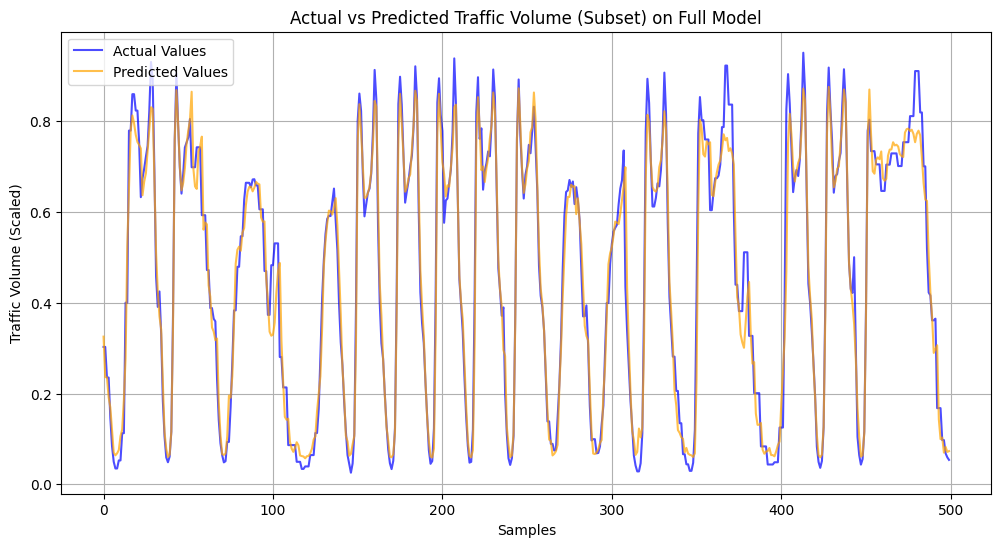

In [ ]:
# Print the best model parameters after tuning
print("Best Random Forest Model Parameters:")
print(best_rf_model)


best_rf_model.fit(X_train, y_train.ravel())

# Evaluate the model
y_pred_full = best_rf_model.predict(X_test)
mse_full = mean_squared_error(y_test, y_pred)
mae_full = mean_absolute_error(y_test, y_pred_full)
rmse_full = np.sqrt(mse_full)
r2_full = r2_score(y_test, y_pred_full)
# Print the evaluation metrics
print("Test MSE:", mse_full)
print("Test MAE:", mae_full)
print("Test RMSE:", rmse_full)
print("Test R^2 Score:", r2_full)

# Plot Actual vs Predicted values for a subset of the test data
subset_size = 500
plt.figure(figsize=(12, 6))
plt.plot(y_test[:subset_size], label='Actual Values', color='blue', alpha=0.7)
plt.plot(y_pred_full[:subset_size], label='Predicted Values', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Traffic Volume (Subset) on Full Model')
plt.xlabel('Samples')
plt.ylabel('Traffic Volume (Scaled)')
plt.legend()
plt.grid()
plt.show()

**SVM Regressor**

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters from RandomizedSearchCV:
{'kernel': 'rbf', 'gamma': 'scale', 'C': 1}

Evaluation on Full Test Set
Test MSE: 0.003584015503697255
Test RMSE: 0.05986664767378624
Test MAE: 0.045519445913743135
Test R^2 Score: 0.9509492705373468


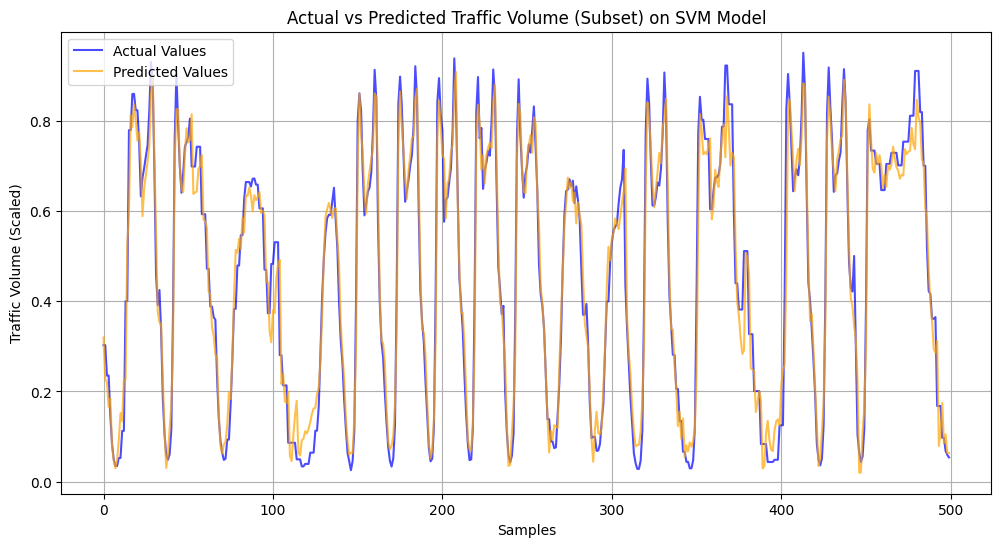

In [ ]:
#SVM Regressor with randomized search

param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],     #  kernel types
    'C': [1, 10],                    # values for C
    'gamma': ['scale', 'auto']       #  gamma options
}


# Initialize RandomizedSearchCV for faster tuning
randomized_search = RandomizedSearchCV(estimator=SVR(),
                                       param_distributions=param_grid,
                                       scoring='neg_mean_squared_error',
                                       cv=3,
                                       n_iter=5,            #  number of combinations
                                       n_jobs=-1,
                                       random_state=42,
                                       verbose=1)
randomized_search.fit(X_train, y_train.ravel())
best_svr_model = randomized_search.best_estimator_

# Fit the best model on the full training data
best_svr_model.fit(X_train, y_train.ravel())

# Evaluate on full test set
y_pred_svr = best_svr_model.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

# Print the best parameter grid
print("Best Parameters from RandomizedSearchCV:")
print(randomized_search.best_params_)

# Print evaluation metrics
print("\nEvaluation on Full Test Set")
print("Test MSE:", mse_svr)
print("Test RMSE:", rmse_svr)
print("Test MAE:", mae_svr)
print("Test R^2 Score:", r2_svr)

# Plot Actual vs Predicted for a subset of data
subset_size = 500
plt.figure(figsize=(12, 6))
plt.plot(y_test[:subset_size], label='Actual Values', color='blue', alpha=0.7)
plt.plot(y_pred_svr[:subset_size], label='Predicted Values', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Traffic Volume (Subset) on SVM Model')
plt.xlabel('Samples')
plt.ylabel('Traffic Volume (Scaled)')
plt.legend()
plt.grid()
plt.show()

Comparison between models:

In [ ]:

# Initialize a dictionary to store evaluation metrics for each model
model_metrics = {}


# Call the function and suppress training details and metrics printed inside the function
f = io.StringIO()  # Create a StringIO object to redirect output
with contextlib.redirect_stdout(f):
    # Call the function and get the required variables
    mse_scaled, mae_scaled, rmse_scaled, r2_scaled, _, _, _, _, _ = train_XGBoost_timeseries_model(df, plot_graphs=False)

print("Model Comparison Metrics:")
print("XGBoost Timeseries:")
print(f"MSE: {mse_scaled:.4f}")
print(f"MAE: {mae_scaled:.4f}")
print(f"RMSE: {rmse_scaled:.4f}")
print(f"R2: {r2_scaled:.4f}")

#RNN (scaled)


mse_tunning_rnn = mean_squared_error(y_test_seq, predictions_scaled2)
mae_tunning_rnn = mean_absolute_error(y_test_seq, predictions_scaled2)
rmse_tunning_rnn = np.sqrt(mse_tunning_rnn)
r_squared_tunning_rnn = r2_score(y_test_seq, predictions_scaled2)
model_metrics['RNN'] = {'MSE': mse_tunning_rnn, 'RMSE': rmse_tunning_rnn, 'MAE': mae_tunning_rnn , 'R2': r_squared_tunning_rnn}


# Decision Tree Regressor
y_pred_dt = best_dt_model.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
model_metrics['Decision Tree'] = {'MSE': mse_dt, 'RMSE': rmse_dt, 'MAE': mae_dt, 'R2': r2_dt}

# Random Forest Regressor
y_pred_rf = best_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
model_metrics['Random Forest'] = {'MSE': mse_rf, 'RMSE': rmse_rf, 'MAE': mae_rf, 'R2': r2_rf}

# SVM Regressor
y_pred_svr = best_svr_model.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
model_metrics['SVM'] = {'MSE': mse_svr, 'RMSE': rmse_svr, 'MAE': mae_svr, 'R2': r2_svr}

# Display the metrics for each model

for model, metrics in model_metrics.items():
    print(f"\n{model} Model:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")




**Conformal Prediction Interval**

In [ ]:
#  Split test set into calibration and final test sets (50% each)
calibration_size = int(len(test_df_XG) * 0.5)
calibration_df, final_test_df = test_df_XG[:calibration_size], test_df_XG[calibration_size:]

# Define calibration and final test sets
X_calibration, y_calibration = calibration_df[lag_features_XG], calibration_df[target_feature_XG]
X_final_test, y_final_test = final_test_df[lag_features_XG], final_test_df[target_feature_XG]

# Convert calibration data to XGBoost DMatrix format
dcalibration = xgb.DMatrix(X_calibration, label=y_calibration)
dfinal_test = xgb.DMatrix(X_final_test, label=y_final_test)

In [ ]:
# Predict on the calibration set and calculate residuals
y_calibration_pred = model_XG.predict(dcalibration)

# Inverse scale predictions and actual values for calibration set
y_calibration_pred_original = scaler_XG.inverse_transform(y_calibration_pred.reshape(-1, 1))
y_calibration_original = scaler_XG.inverse_transform(y_calibration.to_numpy().reshape(-1, 1))

# Calculate residuals for calibration set
residuals = np.abs(y_calibration_original - y_calibration_pred_original)

In [ ]:
# Calculate the quantile for the desired confidence level
confidence_level = 0.95  # For 95% prediction intervals
quantile_conformal = np.quantile(residuals, confidence_level)

In [ ]:
# Predict on the final test set using scaled values
y_final_test_pred = model_XG.predict(dfinal_test)

In [ ]:
# Inverse scale predictions and actual values for final test set to use for CIs and plotting
y_final_test_pred_original = scaler_XG.inverse_transform(y_final_test_pred.reshape(-1, 1))
y_final_test_original = scaler_XG.inverse_transform(y_final_test.to_numpy().reshape(-1, 1))

In [ ]:
# Calculate conformal prediction interval bounds using the original scale
lower_bound_conformal = y_final_test_pred_original - quantile_conformal
upper_bound_conformal = y_final_test_pred_original + quantile_conformal

**Confidence Intervals**

In [ ]:
# Calculate quantile-based interval bounds on the original scale (95% confidence)
std_dev_original = np.std(y_final_test_pred_original)

quantile_regular = 1.96   # 95% confidence interval for a normal distribution
lower_bound_regular = y_final_test_pred_original - quantile_regular * std_dev_original
upper_bound_regular = y_final_test_pred_original + quantile_regular * std_dev_original


In [ ]:
# Calculate coverage for both intervals on the original scale
coverage_conformal = np.mean((y_final_test_original >= lower_bound_conformal) & (y_final_test_original <= upper_bound_conformal))
coverage_regular = np.mean((y_final_test_original >= lower_bound_regular) & (y_final_test_original <= upper_bound_regular))

In [ ]:
# Print coverage results on original scale (What level of CI ??? check)
print("\n--- Conformal vs. Regular Quantile Prediction Intervals (Original Scale) ---")
print(f"Desired confidence level: {confidence_level * 100}%")
print(f"Conformal Prediction Interval Coverage: {coverage_conformal * 100:.2f}%")
print(f"Regular Quantile-Based Interval Coverage: {coverage_regular * 100:.2f}%")
print("-" * 35)


--- Conformal vs. Regular Quantile Prediction Intervals (Original Scale) ---
Desired confidence level: 95.0%
Conformal Prediction Interval Coverage: 95.89%
Regular Quantile-Based Interval Coverage: 100.00%
-----------------------------------


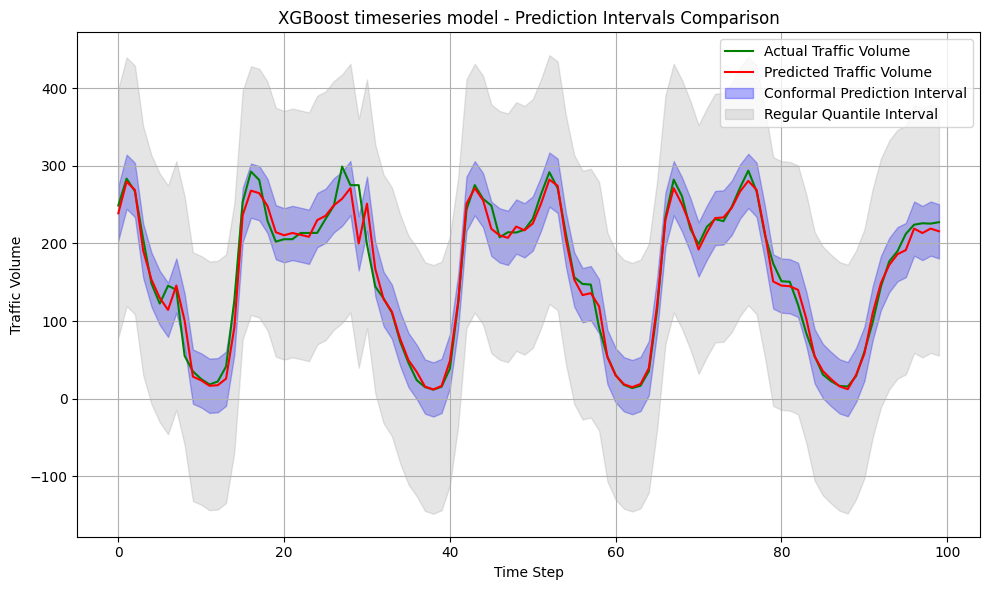

In [ ]:
# Plot actual vs predicted with conformal and regular prediction intervals (in original scale)
plt.figure(figsize=(10, 6))
plt.plot(range(100), y_final_test_original[:100], label='Actual Traffic Volume', color='green')
plt.plot(range(100), y_final_test_pred_original[:100], label='Predicted Traffic Volume', color='red')
plt.fill_between(range(100), lower_bound_conformal[:100].flatten(), upper_bound_conformal[:100].flatten(),
                 color='blue', alpha=0.3, label='Conformal Prediction Interval')
plt.fill_between(range(100), lower_bound_regular[:100].flatten(), upper_bound_regular[:100].flatten(),
                 color='gray', alpha=0.2, label='Regular Quantile Interval')
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Traffic Volume")
plt.title('XGBoost timeseries model - Prediction Intervals Comparison')
plt.grid(True)
plt.tight_layout()
plt.show()